In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_excel("Unificado_def_2015_2025.xlsx")
df['datetime_utc'] = pd.to_datetime(df['datetime_utc']).dt.tz_localize(None)
df = df.drop(columns=['geo_id', 'geo_name'], errors='ignore')
df = df.rename(columns={'datetime_utc': 'ds', 'value': 'y'})

df['hour'] = df['ds'].dt.hour
df['minute'] = df['ds'].dt.minute
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month

festivos = [
    '2025-01-01', '2025-01-06', '2025-03-20', '2025-03-21',
    '2025-05-01', '2025-08-15', '2025-10-12',
    '2025-11-01', '2025-12-06', '2025-12-08', '2025-12-25'
]
festivos_df = pd.DataFrame({
    'ds': pd.to_datetime(festivos),
    'holiday': 'festivo',
    'lower_window': -1,
    'upper_window': 1
})

def entrenar_y_predecir(df, festivos_df, horizon_days):
    split_date = df['ds'].max() - pd.Timedelta(days=horizon_days)
    train = df[df['ds'] <= split_date]
    valid = df[df['ds'] > split_date]

    best_params = {
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 10,
        'holidays_prior_scale': 0.1,
        'changepoint_range': 0.9
    }

    m = Prophet(
        holidays=festivos_df,
        seasonality_mode='multiplicative',
        yearly_seasonality=20,
        weekly_seasonality=10,
        daily_seasonality=24,
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        changepoint_range=best_params['changepoint_range']
    )
    m.add_seasonality(name='intradaily', period=0.5, fourier_order=15)
    m.add_seasonality(name='hourly', period=1/24, fourier_order=12)
    m.add_regressor('hour')
    m.add_regressor('dayofweek')
    m.add_regressor('minute')
    m.add_regressor('month')
    m.fit(train)

    future_valid = m.make_future_dataframe(periods=len(valid), freq='10min')
    future_valid['hour'] = future_valid['ds'].dt.hour
    future_valid['minute'] = future_valid['ds'].dt.minute
    future_valid['dayofweek'] = future_valid['ds'].dt.dayofweek
    future_valid['month'] = future_valid['ds'].dt.month

    forecast_valid = m.predict(future_valid)
    comparison = forecast_valid[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(valid, on='ds')

    mae = mean_absolute_error(comparison['y'], comparison['yhat'])
    rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
    mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

    return comparison, mae, rmse, mape, m

resultados = {}
horizontes = {'24 horas': 1, '3 dias': 3, '1 semana': 7}
for nombre, dias in horizontes.items():
    comp, mae, rmse, mape, modelo = entrenar_y_predecir(df, festivos_df, dias)
    resultados[nombre] = {
        'comparison': comp,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'modelo': modelo
    }

for nombre, res in resultados.items():
    print(f"\nResultados para horizonte {nombre}:")
    print(f"MAE: {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print(f"MAPE: {res['mape']:.2f}%")




21:16:42 - cmdstanpy - INFO - Chain [1] start processing
21:34:42 - cmdstanpy - INFO - Chain [1] done processing
21:49:42 - cmdstanpy - INFO - Chain [1] start processing
22:10:33 - cmdstanpy - INFO - Chain [1] done processing
22:24:48 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] done processing



Resultados para horizonte 24 horas:
MAE: 983.72
RMSE: 1162.90
MAPE: 4.14%

Resultados para horizonte 3 dias:
MAE: 1282.58
RMSE: 1703.84
MAPE: 4.99%

Resultados para horizonte 1 semana:
MAE: 1560.47
RMSE: 2036.53
MAPE: 6.20%


In [ ]:
comp_3_2 = resultados['3 dias']['comparison']
plt.figure(figsize=(15, 6))
plt.plot(comp_3_2['ds'], comp_3_2['y'], label='Real', color='blue', alpha=0.7)
plt.plot(comp_3_2['ds'], comp_3_2['yhat'], label='Predicción', color='orange', alpha=0.7)
plt.fill_between(comp_3_2['ds'], comp_3_2['yhat_lower'], comp_3_2['yhat_upper'],
                 color='orange', alpha=0.2, label='Intervalo de confianza')
plt.title('Comparación: Real vs Predicción (Validación 3 días)')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()1
plt.show()

fig = resultados['3 dias']['modelo'].plot_components(resultados['3 dias']['modelo'].predict(resultados['3 dias']['comparison']))
plt.tight_layout()
plt.show()

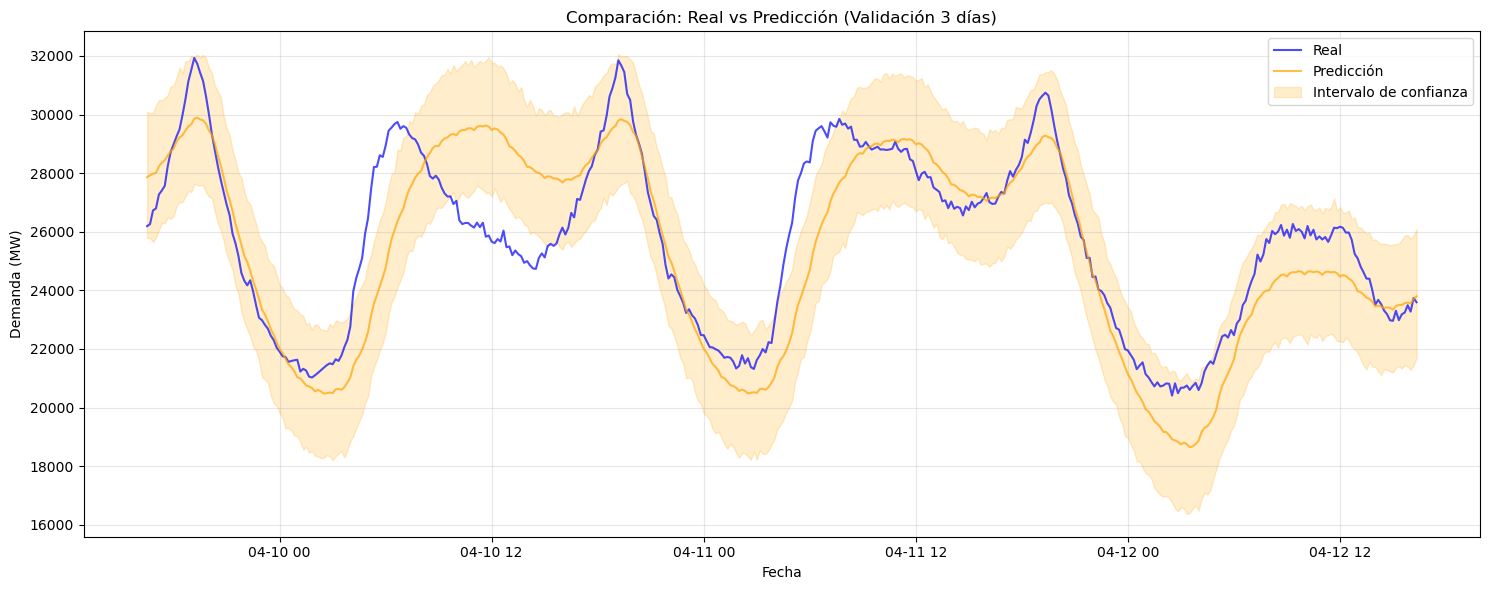

C:\Users\Mario\AppData\Local\Temp\ipykernel_20988\3714274769.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


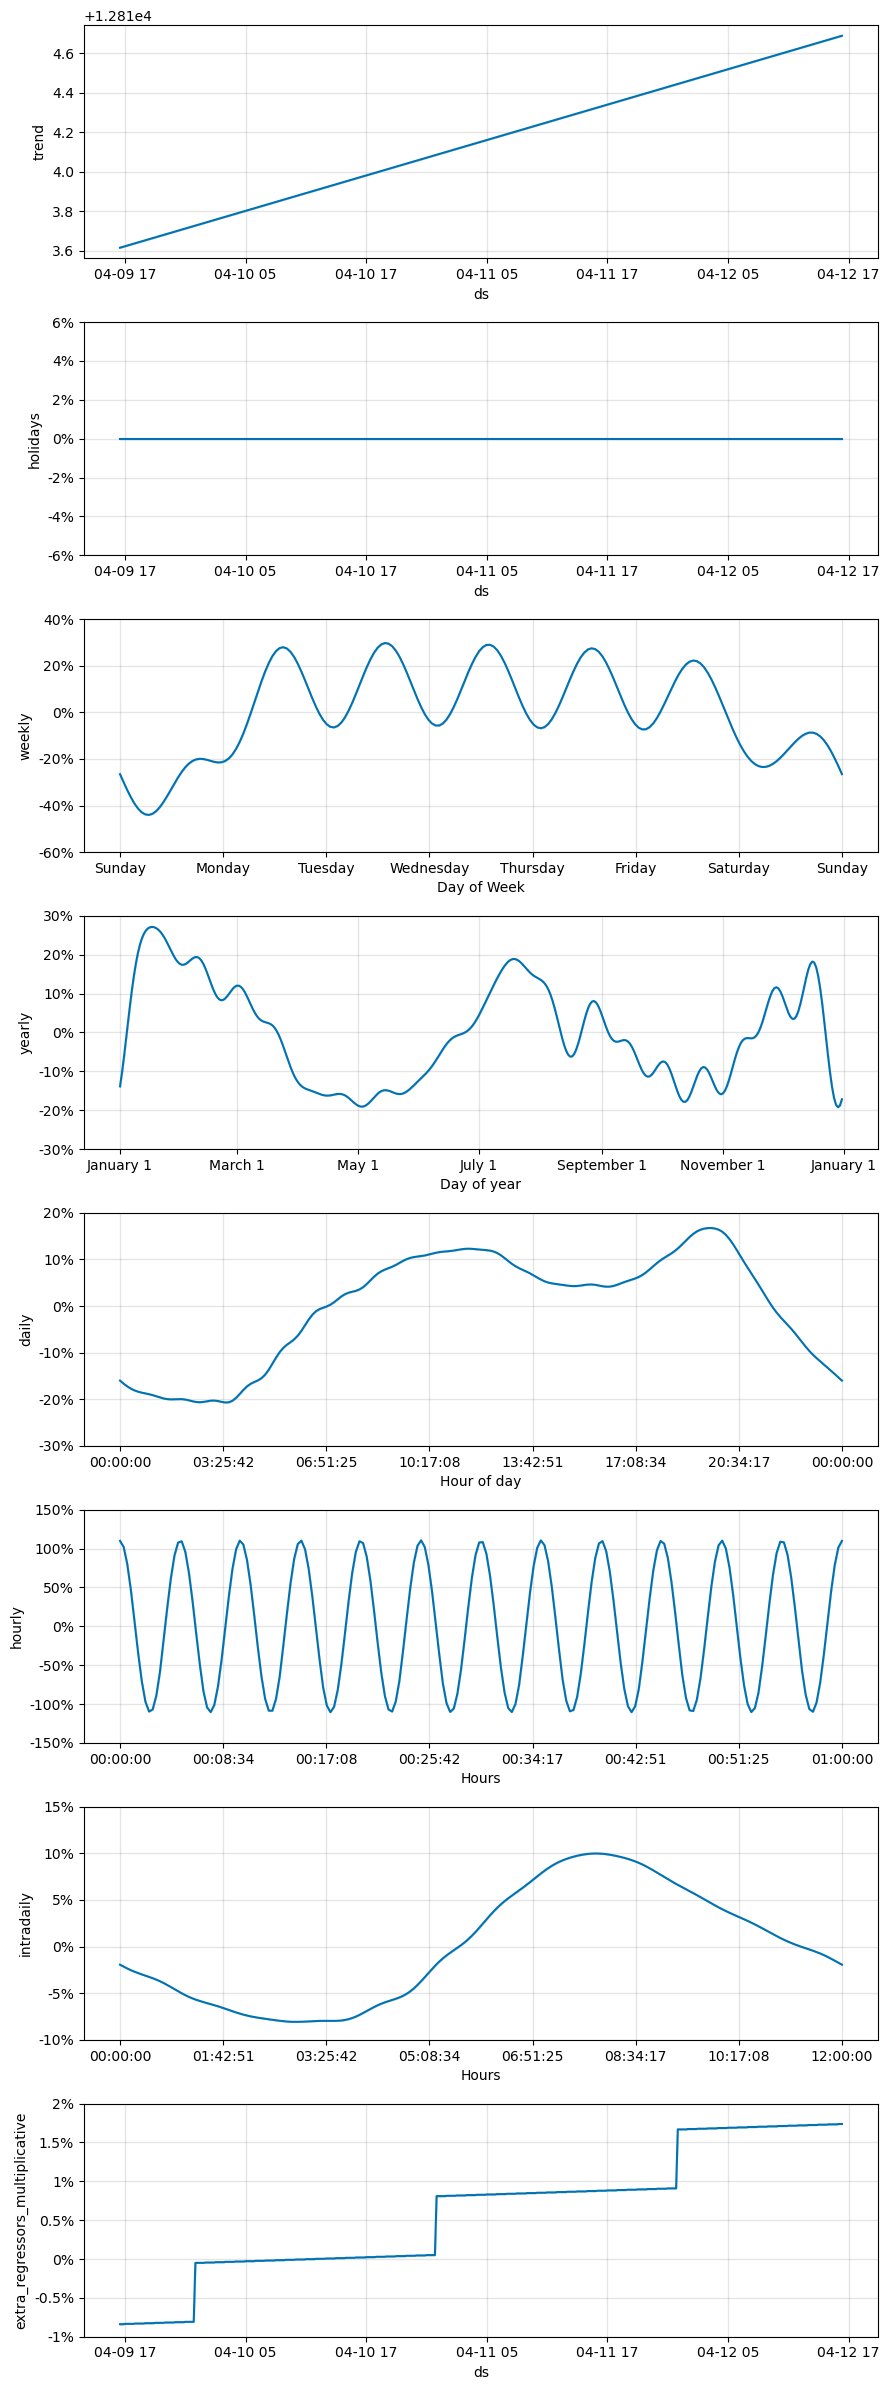

In [ ]:
comp_3d = resultados['3 dias']['comparison']
plt.figure(figsize=(15, 6))
plt.plot(comp_3d['ds'], comp_3d['y'], label='Real', color='blue', alpha=0.7)
plt.plot(comp_3d['ds'], comp_3d['yhat'], label='Predicción', color='orange', alpha=0.7)
plt.fill_between(comp_3d['ds'], comp_3d['yhat_lower'], comp_3d['yhat_upper'],
                 color='orange', alpha=0.2, label='Intervalo de confianza')
plt.title('Comparación: Real vs Predicción (Validación 3 días)')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig = resultados['3 dias']['modelo'].plot_components(resultados['3 dias']['modelo'].predict(resultados['3 dias']['comparison']))
plt.tight_layout()
plt.show()


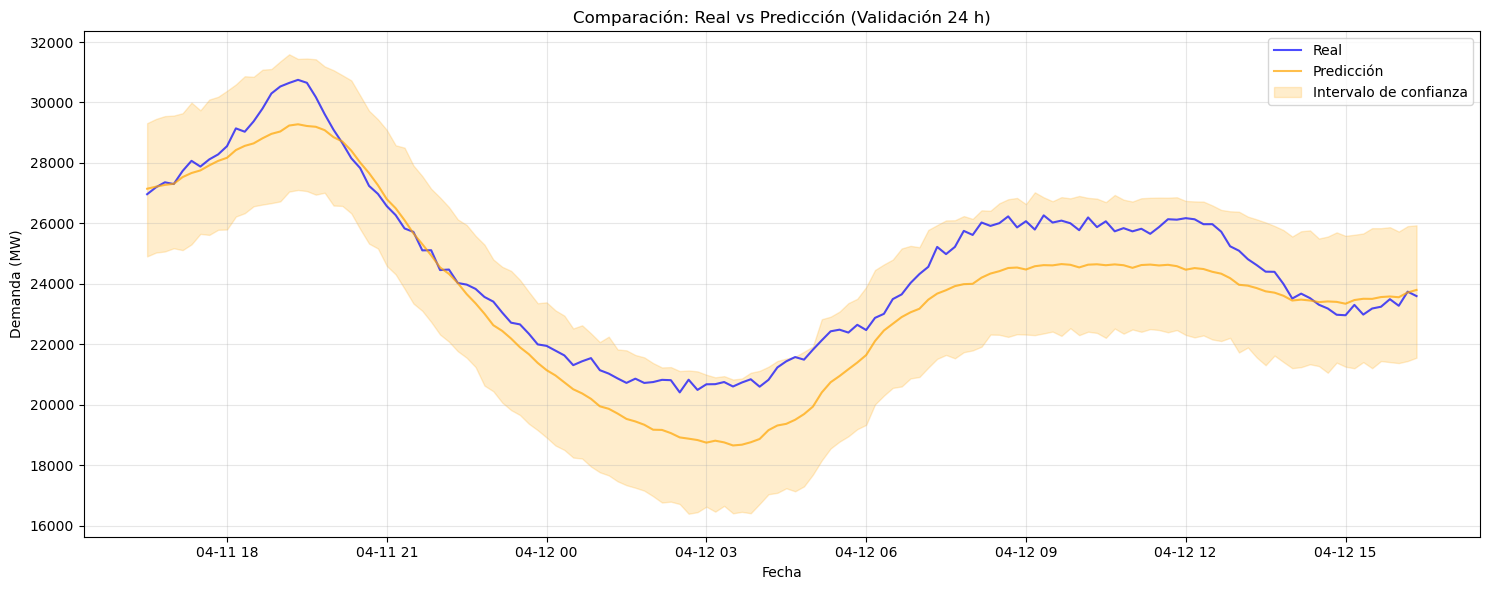

C:\Users\Mario\AppData\Local\Temp\ipykernel_20988\1077936671.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


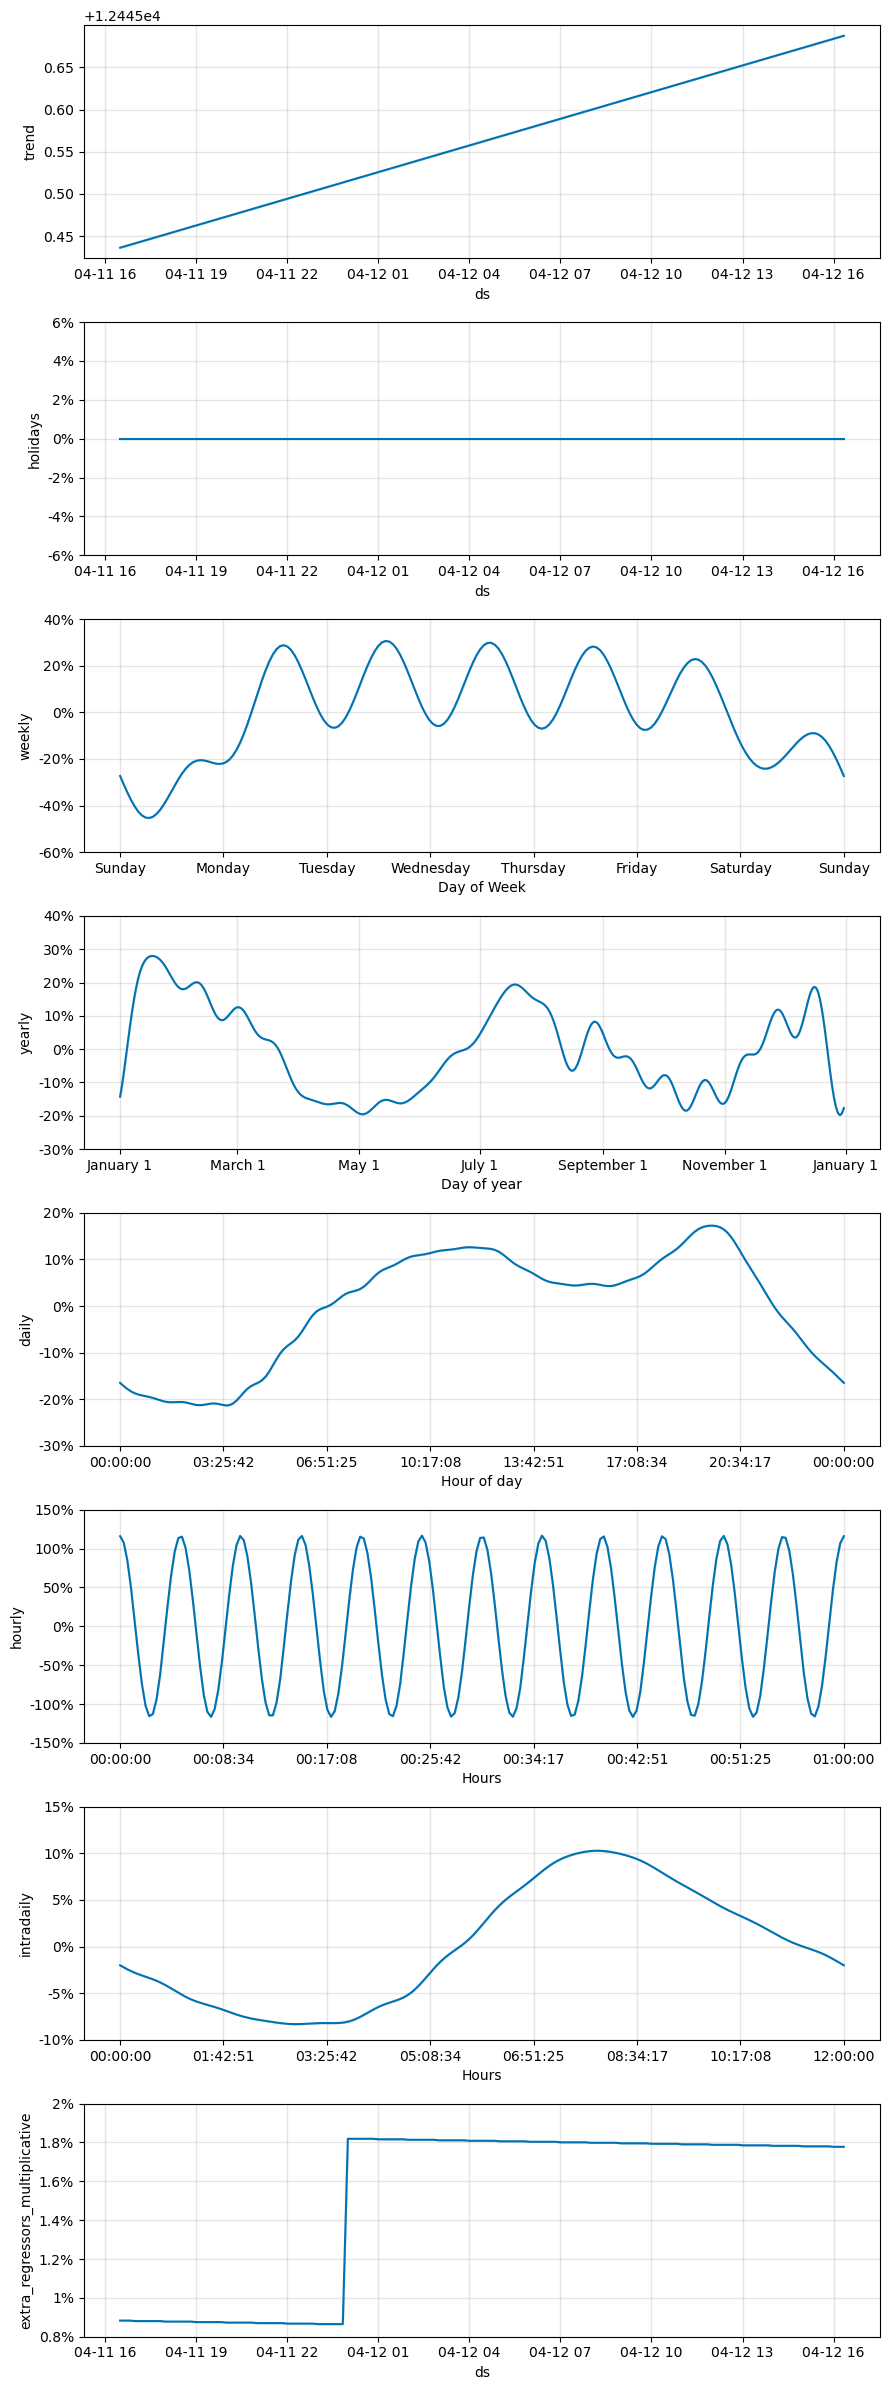

In [ ]:
comp_24h = resultados['24 horas']['comparison']
plt.figure(figsize=(15, 6))
plt.plot(comp_24h['ds'], comp_24h['y'], label='Real', color='blue', alpha=0.7)
plt.plot(comp_24h['ds'], comp_24h['yhat'], label='Predicción', color='orange', alpha=0.7)
plt.fill_between(comp_24h['ds'], comp_24h['yhat_lower'], comp_24h['yhat_upper'],
                 color='orange', alpha=0.2, label='Intervalo de confianza')
plt.title('Comparación: Real vs Predicción (Validación 24 h)')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig = resultados['24 horas']['modelo'].plot_components(resultados['24 horas']['modelo'].predict(resultados['24 horas']['comparison']))
plt.tight_layout()
plt.show()


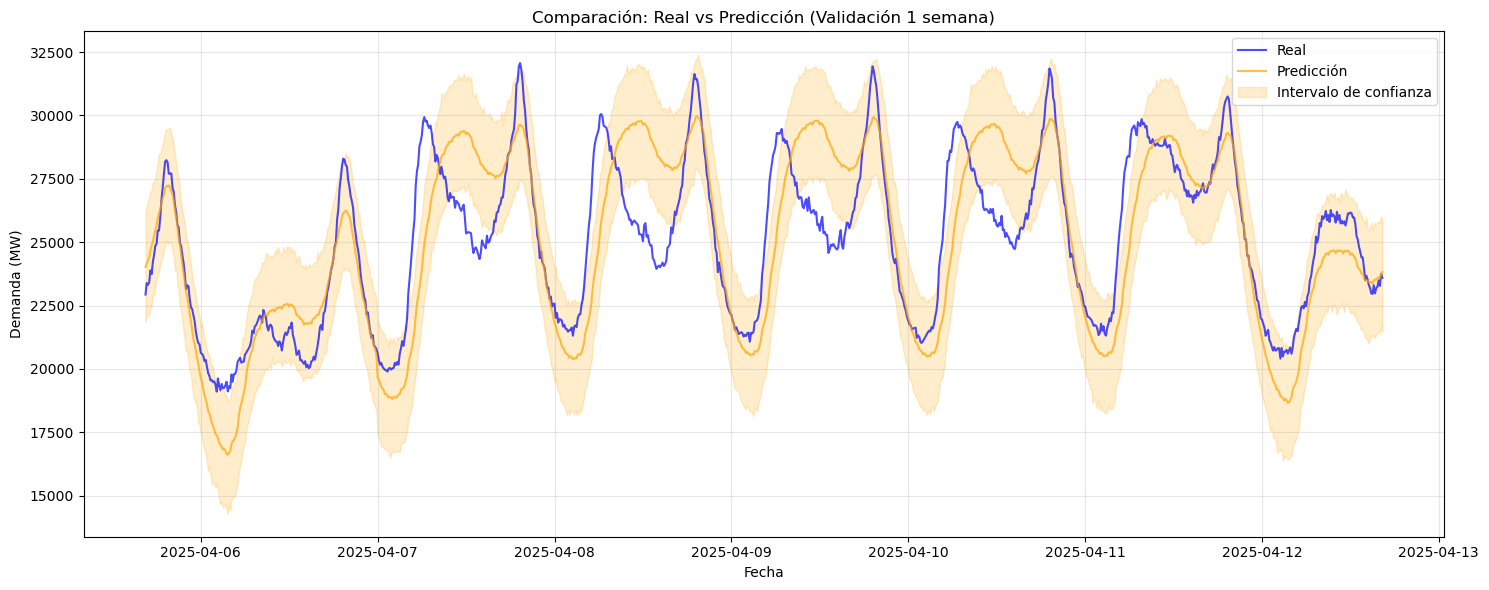

C:\Users\Mario\AppData\Local\Temp\ipykernel_20988\2989381583.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


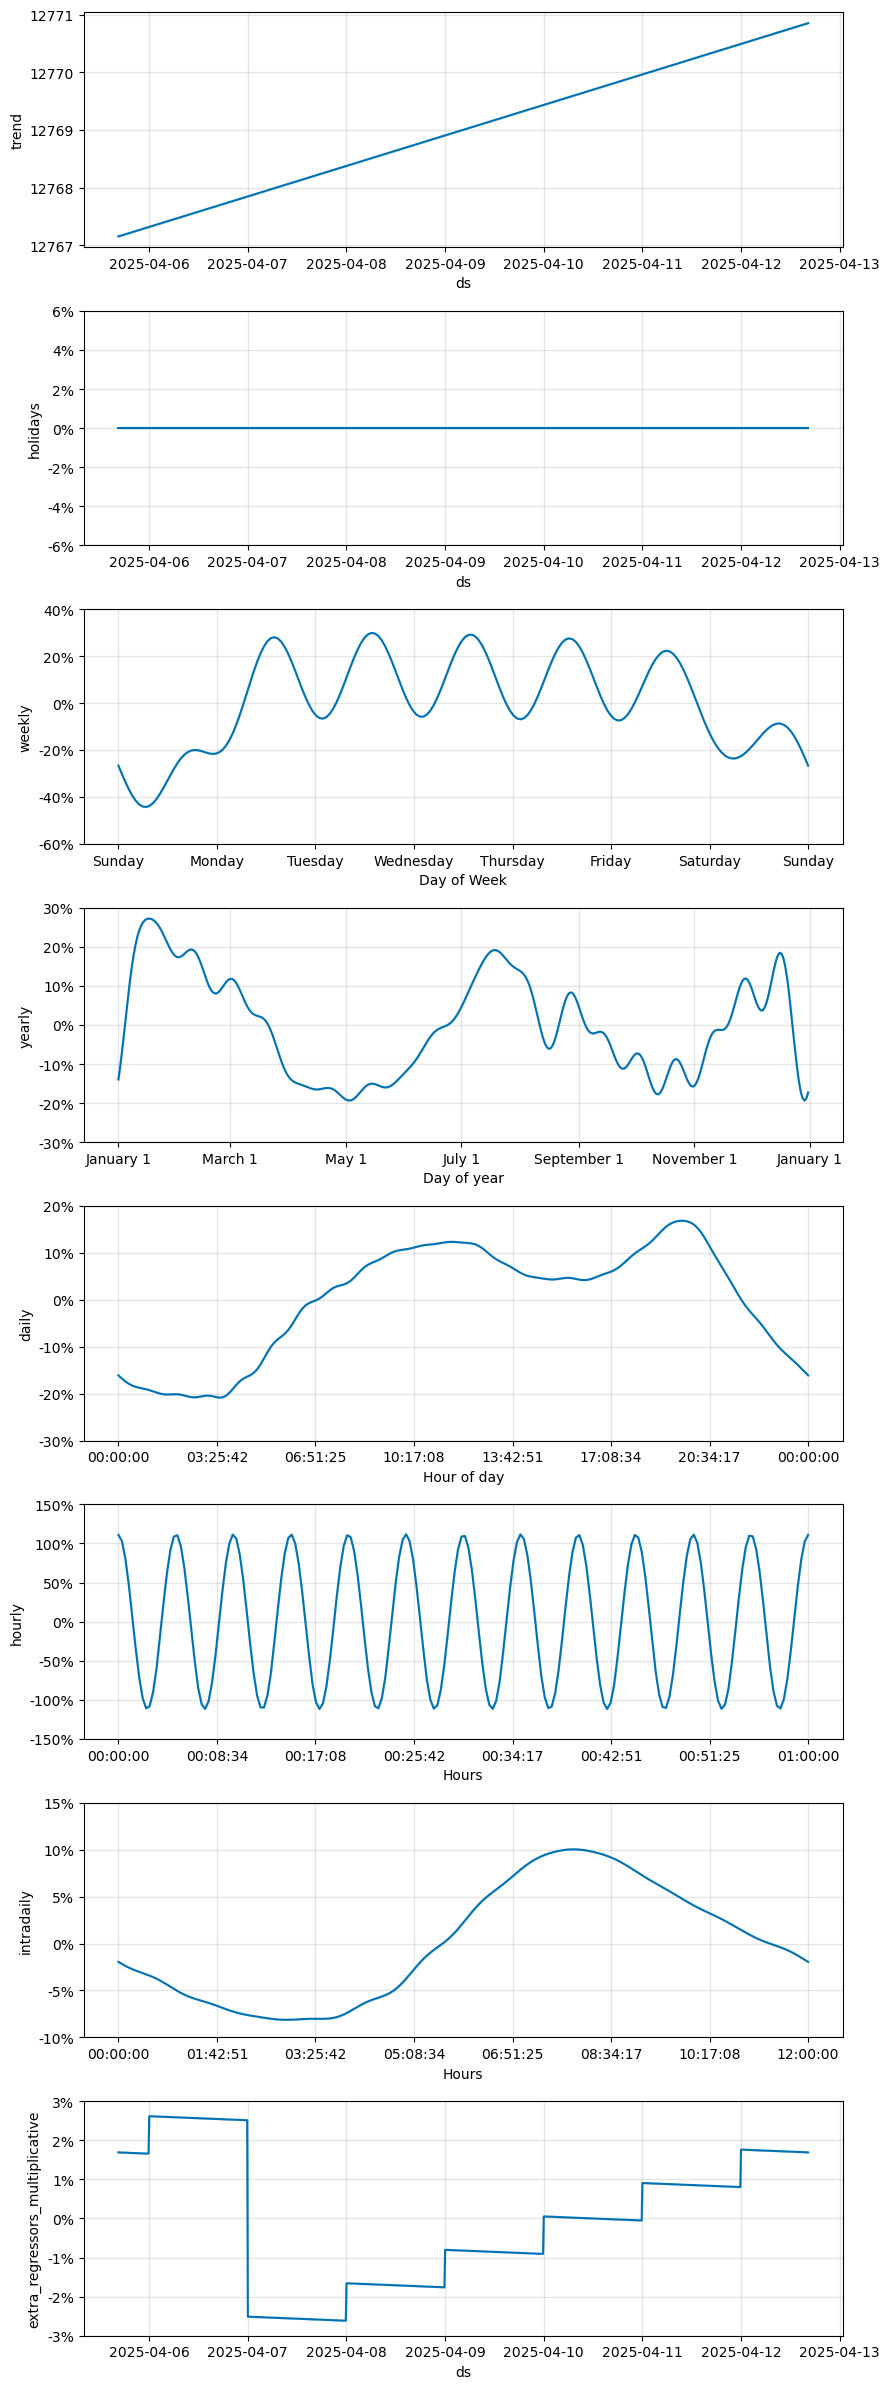

In [ ]:
semana = resultados['1 semana']['comparison']
plt.figure(figsize=(15, 6))
plt.plot(semana['ds'], semana['y'], label='Real', color='blue', alpha=0.7)
plt.plot(semana['ds'], semana['yhat'], label='Predicción', color='orange', alpha=0.7)
plt.fill_between(semana['ds'], semana['yhat_lower'], semana['yhat_upper'],
                 color='orange', alpha=0.2, label='Intervalo de confianza')
plt.title('Comparación: Real vs Predicción (Validación 1 semana)')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig = resultados['1 semana']['modelo'].plot_components(resultados['1 semana']['modelo'].predict(resultados['1 semana']['comparison']))
plt.tight_layout()
plt.show()